# Workspace - Challenge 1

In [1]:
%load_ext autoreload
%autoreload 2

In [24]:
import numpy as np
import pandas as pd

In [27]:
from lumen.io import read_events
from lumen.io import read_positions
from lumen.util import extract_device_events
from lumen.util import plot_devices

from lumen.device import Device
from lumen.model_greed import ModelGreed

## Read data

In [4]:
df_events = read_events('site_1')
df_positions = read_positions('site_1')

In [5]:
events_map = extract_device_events(df_events)
print(f"Number of mapped devices: {len(events_map.keys())}")

Number of mapped devices: 56


In [6]:
device_id_list = sorted(df_events.deviceid.unique())

train_size = int(0.5 * len(device_id_list))
train_device_id_list = np.random.choice(device_id_list, train_size, replace=False)
test_device_id_list = [x for x in device_id_list if x not in train_device_id_list]

len(train_device_id_list), len(test_device_id_list)

(28, 28)

In [7]:
devices_pos = df_positions.set_index('deviceid')

In [10]:
devices = []
real_device_id_to_position_map = {}

for device_id in device_id_list:
    point = devices_pos.loc[device_id]
    position = [point.x, point.y]
    _device = Device(position=position, device_id=None)    
    if device_id in train_device_id_list:
        # Add as known device
        _device.set_device_id(device_id)

    devices.append(_device)
    # To calculate loss
    real_device_id_to_position_map[device_id] = [point.x, point.y]

In [13]:
known_devices = [device for device in devices if device.has_device_id()]
device_id_candidates = set(test_device_id_list)

len(known_devices), len(device_id_candidates)

(28, 28)

In [17]:
model = ModelGreed(devices)
model.fit(df_events)
model.map_unknowns(test_device_id_list)

In [18]:
# Calculate loss
loss = 0
for device in devices:
    position = device.position
    real_position = real_device_id_to_position_map.get(device.device_id)
    loss += ((position[0] - real_position[0])**2 + (position[1] - real_position[1])**2)**0.5

loss

5312.234049355525

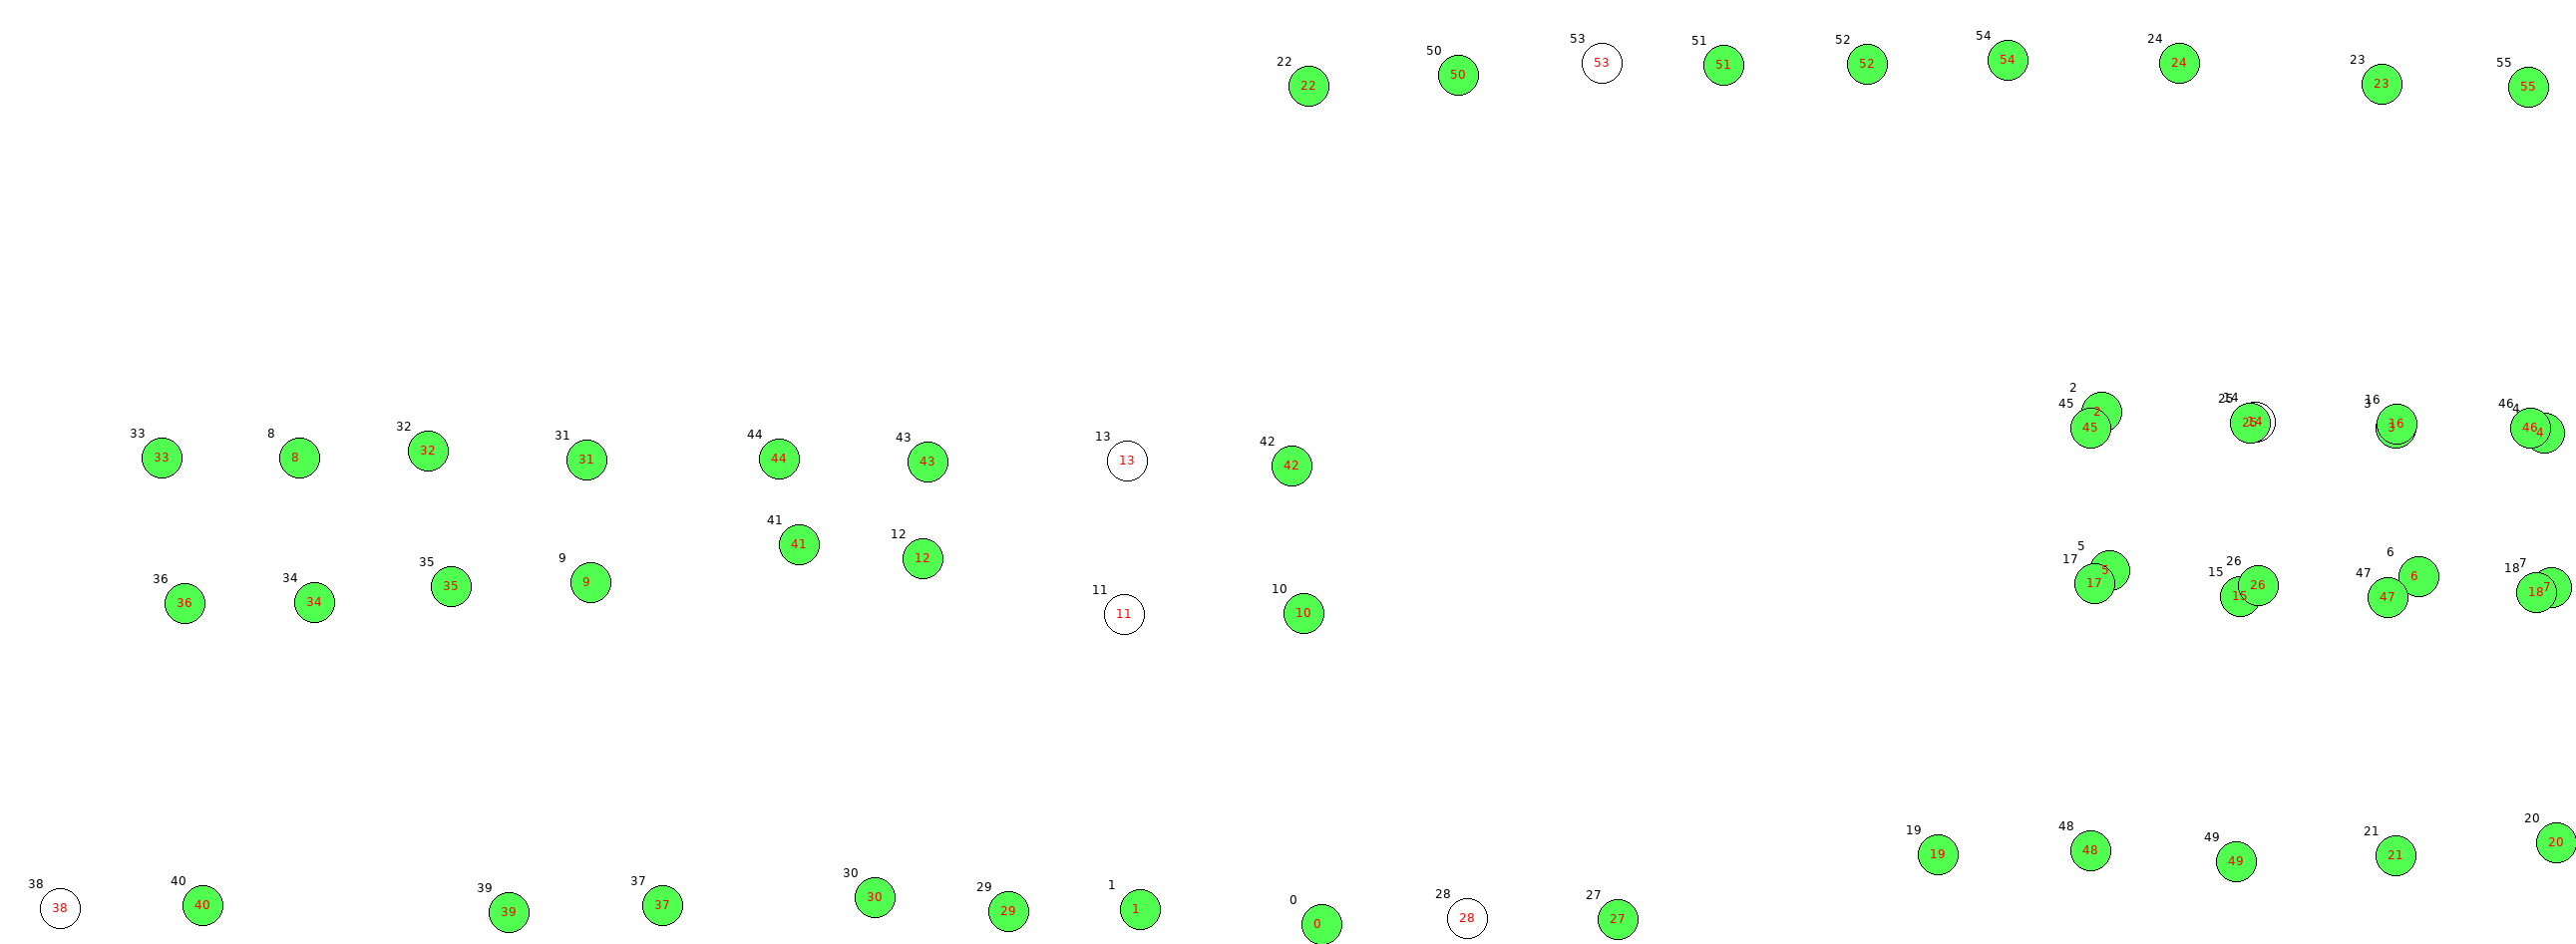

In [32]:
device_id_list = sorted(df_events.deviceid.unique())

plot_devices(devices,
             device_id_list=device_id_list, 
             to_file="model_greed_output.png", 
             text_size=12, 
             radius=40, 
             train_device_id_list=train_device_id_list, 
             real_device_id_to_position_map=real_device_id_to_position_map)

In [ ]:
device_id_list = sorted(df_events.deviceid.unique())

plot_devices(devices,
             device_id_list=device_id_list, 
             to_file="model_greed_output.png", 
             text_size=12, 
             radius=40, 
             train_device_id_list=train_device_id_list, 
             real_device_id_to_position_map=real_device_id_to_position_map)

In [22]:
errors = []
splits = [0.1, 0.2, 0.5, 0.7, 0.9]

for split in splits:
    print(f"... estimating loss for split: {split}")
    train_size = int(split * len(device_id_list))
    train_device_id_list = np.random.choice(device_id_list, train_size, replace=False)
    test_device_id_list = [x for x in device_id_list if x not in train_device_id_list]
    
    devices = []
    real_device_id_to_position_map = {}
    for device_id in device_id_list:
        point = devices_pos.loc[device_id]
        position = [point.x, point.y]
        _device = Device(position=position, device_id=None)    
        if device_id in train_device_id_list:
            # Add as known device
            _device.set_device_id(device_id)
        devices.append(_device)
        # To calculate loss
        real_device_id_to_position_map[device_id] = [point.x, point.y]
    
    known_devices = [device for device in devices if device.has_device_id()]
    device_id_candidates = set(test_device_id_list)
    
    model = ModelGreed(devices)
    model.fit(df_events)
    model.map_unknowns(test_device_id_list)
    
    # Calculate loss
    loss = 0
    for device in devices:
        position = device.position
        real_position = real_device_id_to_position_map.get(device.device_id)
        loss += ((position[0] - real_position[0])**2 + (position[1] - real_position[1])**2)**0.5

    errors.append(loss)

... estimating loss for split: 0.1
... estimating loss for split: 0.2
... estimating loss for split: 0.5
... estimating loss for split: 0.7
... estimating loss for split: 0.9


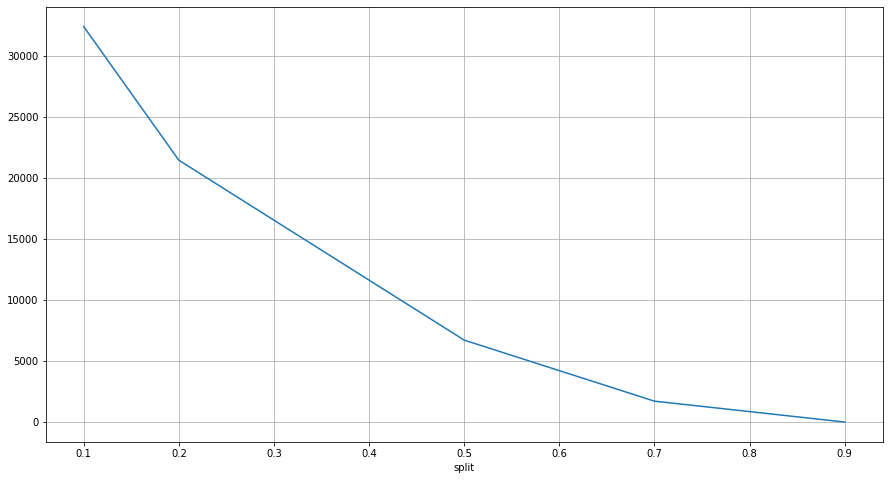

In [25]:
df = pd.DataFrame()
df['split'] = splits
df['error'] = errors

_ = df.set_index('split').error.plot(figsize=(15, 8), grid=True)

In [33]:
from datetime import timedelta

split = 0.5
delta_times = [7, 14, 21, 28]

errors = []
days = []

for i in range(10):
    print(f"... run: {i}")

    for delta_time in delta_times:
        time_window_start = df_events.timestamp.min()
        time_window_end = time_window_start + timedelta(days=delta_time)
        sub_df_events = df_events[df_events.timestamp < time_window_end]
        train_size = int(split * len(device_id_list))
        train_device_id_list = np.random.choice(device_id_list, train_size, replace=False)
        test_device_id_list = [x for x in device_id_list if x not in train_device_id_list]
        devices = []
        real_device_id_to_position_map = {}
        for device_id in device_id_list:
            point = devices_pos.loc[device_id]
            position = [point.x, point.y]
            _device = Device(position=position, device_id=None)    
            if device_id in train_device_id_list:
                # Add as known device
                _device.set_device_id(device_id)
            devices.append(_device)
            # To calculate loss
            real_device_id_to_position_map[device_id] = [point.x, point.y]

        known_devices = [device for device in devices if device.has_device_id()]
        device_id_candidates = set(test_device_id_list)

        model = ModelGreed(devices)
        model.fit(sub_df_events)
        model.map_unknowns(test_device_id_list)

        # Calculate loss
        loss = 0
        for device in devices:
            position = device.position
            real_position = real_device_id_to_position_map.get(device.device_id)
            loss += ((position[0] - real_position[0])**2 + (position[1] - real_position[1])**2)**0.5

        days.append(delta_time)
        errors.append(loss)

... run: 0
... run: 1
... run: 2
... run: 3
... run: 4
... run: 5
... run: 6
... run: 7
... run: 8
... run: 9


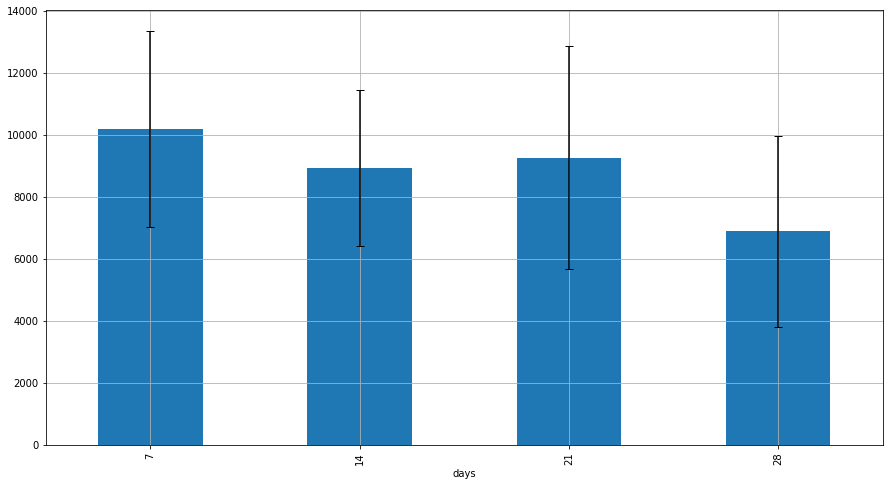

In [34]:
df = pd.DataFrame()
df['days'] = days
df['error'] = errors
yerr = df.groupby('days').error.std()
_ = df.groupby('days').error.mean().plot.bar(figsize=(15, 8), grid=True, yerr=yerr, capsize=4)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=e19bc3ac-22fd-4ca3-9f23-d099570b4b40' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>